# Initial Conditions Exploration for USR Phase in Higgs Inflation

This notebook explores the phase space of initial conditions $(\phi_i, y_i)$ to find suitable trajectories that lead to a sustained Ultra-Slow Roll (USR) phase.

## Objectives
1. **Broad Phase-Space Scan**: Map the duration of the USR phase ($\eta \approx -6$) across a wide range of initial conditions.
2. **CMB Scale Analysis**: Perform a high-resolution scan at the physical CMB scale ($\phi \approx 5.42$).
3. **Dynamics Visualization**: visualize the evolution of the Hubble friction parameter $\delta_H$ (code `etaH`) to confirm it approaches the critical value of +3 during USR.

In [1]:
import sys
import os
# Ensure robust path configuration
root_dir = os.path.abspath('..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

import numpy as np
import matplotlib.pyplot as plt
from inflation_models import HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

## 1. Broad Phase-Space Scan (USR Duration)

We scan over a grid of initial field values $\phi_i$ and initial velocities $y_i$ to see where significant USR phases occur.

### Parameter Definitions:
- $y_i$: Initial velocity (negative values for downward field motion).
- $\eta_{USR} = 2(\epsilon_H - \delta_H) \approx -6$ during USR.
- **USR Condition**: We define a "significant" USR phase as one where $-6.5 < \eta < -5.5$.

In [12]:
# Scan Parameters
phi_grid = np.linspace(5.0, 6.0, 30)
y_grid = -np.logspace(-2, 0, 30) # From -1e-5 to -0.1

duration_grid = np.zeros((len(y_grid), len(phi_grid)))

print(f"Running {len(phi_grid)*len(y_grid)} simulations...")

for i, y in enumerate(y_grid):
    for j, phi in enumerate(phi_grid):
        model = HiggsModel()
        model.xi = phi
        model.yi = y
        
        try:
            # Run until slow-roll ends or we get enough data
            T_span = np.linspace(0, 50, 500) 
            sol = run_background_simulation(model, T_span)
            data = get_derived_quantities(sol, model)
            
            # Calculate eta
            eta = 2 * (data['epsH'] - data['etaH'])
            N = data['N']
            
            # Detect USR Duration
            # Window: -6.5 < eta < -5.5
            usr_mask = (eta > -6.5) & (eta < -5.5)
            
            if np.any(usr_mask):
                # Approximate duration using spacing of N
                # (assuming roughly uniform N steps if we used dense T output, but T_span is fixed)
                # Better: integrate dN over mask regions
                dN = np.diff(N)
                # Create mask for intervals (using left endpoint)
                mask_intervals = usr_mask[:-1]
                duration = np.sum(dN[mask_intervals])
                duration_grid[i, j] = duration
            else:
                duration_grid[i, j] = 0.0
                
        except Exception as e:
            duration_grid[i, j] = 0.0

print("Scan complete.")

Running 900 simulations...
Scan complete.


<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
C:\Users\diego\AppData\Local\Temp\ipykernel_19820\280363891.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('Initial Field $\phi_i$')


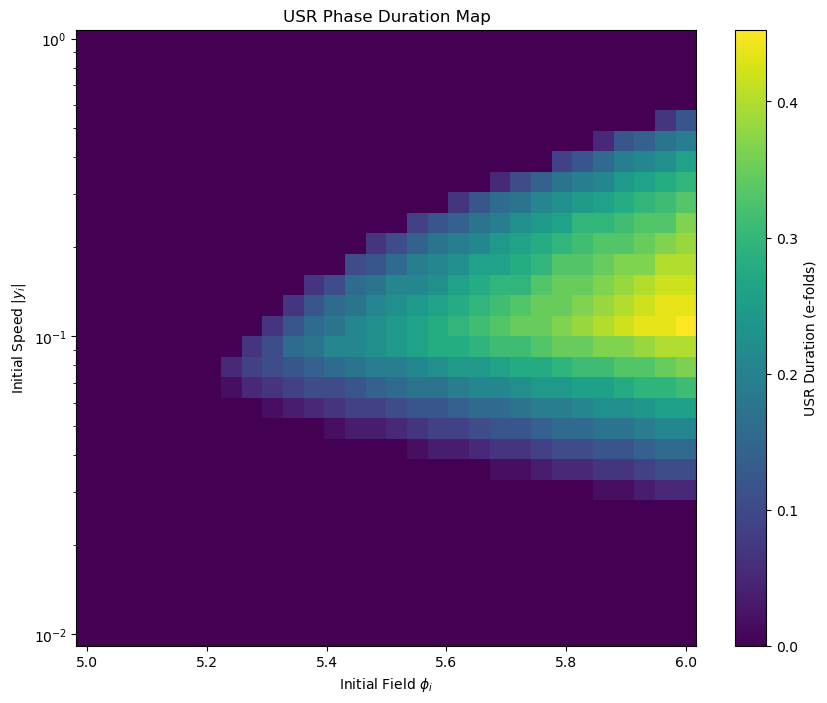

In [13]:
# Plot Heatmap
plt.figure(figsize=(10, 8))
PHI, Y = np.meshgrid(phi_grid, np.abs(y_grid))
plt.pcolormesh(PHI, Y, duration_grid, cmap='viridis', shading='auto')
plt.colorbar(label='USR Duration (e-folds)')
plt.yscale('log')
plt.xlabel('Initial Field $\phi_i$')
plt.ylabel('Initial Speed $|y_i|$')
plt.title('USR Phase Duration Map')
plt.show()

## 2. High-Resolution Scan at CMB Scale ($\phi \approx 5.42$)

Now we focus on the specific physical scale relevant for CMB observations.
We fix $\phi_i = 5.42$ and fine-tune $y_i$ to find the transition to USR.

<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\d'
C:\Users\diego\AppData\Local\Temp\ipykernel_19820\3664268317.py:28: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Minimum $\eta_{USR}$')
C:\Users\diego\AppData\Local\Temp\ipykernel_19820\3664268317.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f'USR Search at $\phi={target_phi}$')
C:\Users\diego\AppData\Local\Temp\ipykernel_19820\3664268317.py:37: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('Maximum $\delta_H$ (etaH)')


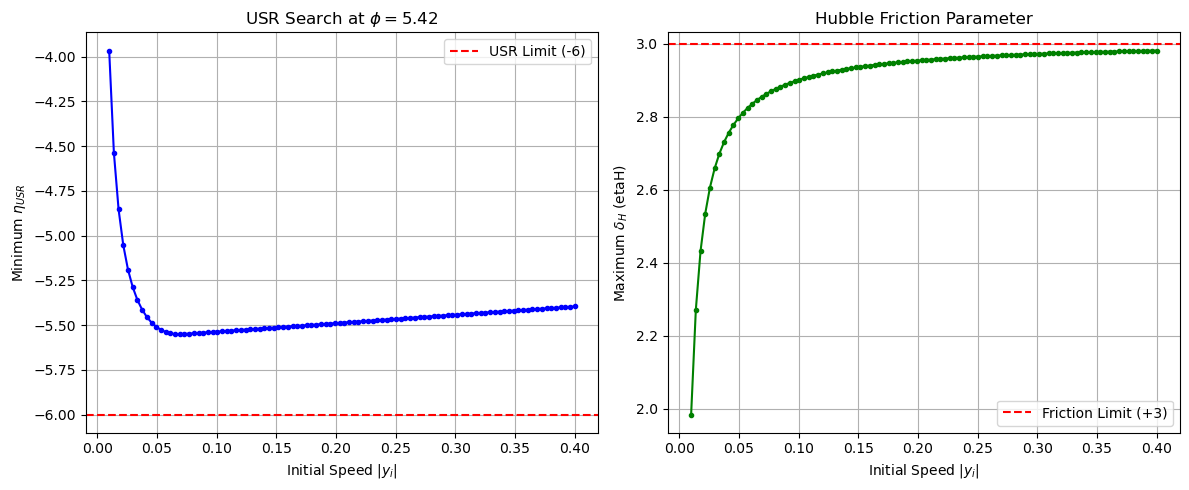

In [14]:
target_phi = 5.42

# Finer grid around the transition region we likely saw in the heatmap
# typically around |y| ~ 0.1 for this model/scale
y_fine = -np.linspace(0.01, 0.4, 100)

min_etas = []
max_deltaH = []

for y in y_fine:
    model = HiggsModel()
    model.xi = target_phi
    model.yi = y
    
    sol = run_background_simulation(model, np.linspace(0, 20, 500))
    data = get_derived_quantities(sol, model)
    
    eta = 2 * (data['epsH'] - data['etaH'])
    min_etas.append(np.min(eta))
    max_deltaH.append(np.max(data['etaH']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.abs(y_fine), min_etas, 'b.-')
plt.axhline(-6, color='r', linestyle='--', label='USR Limit (-6)')
plt.xlabel('Initial Speed $|y_i|$')
plt.ylabel('Minimum $\eta_{USR}$')
plt.title(f'USR Search at $\phi={target_phi}$')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.abs(y_fine), max_deltaH, 'g.-')
plt.axhline(3, color='r', linestyle='--', label='Friction Limit (+3)')
plt.xlabel('Initial Speed $|y_i|$')
plt.ylabel('Maximum $\delta_H$ (etaH)')
plt.title('Hubble Friction Parameter')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Visualizing the "Golden" Trajectory

Based on the scan above, we pick a velocity that achieves $\delta_H \approx 3$ (and thus $\eta \approx -6$).
From previous analysis, we expect $|y_i| \approx 0.1$.

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
C:\Users\diego\AppData\Local\Temp\ipykernel_19820\2021650424.py:24: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f'Dynamics for $\phi_i={target_phi}, y_i={golden_y}$')


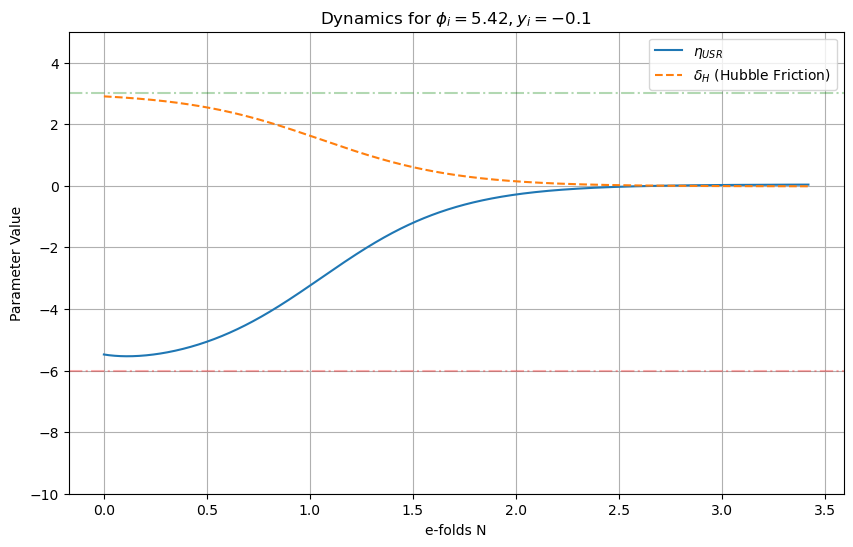

In [15]:
# Selected Fine-Tuned Velocity
golden_y = -0.1

model = HiggsModel()
model.xi = target_phi
model.yi = golden_y

sol = run_background_simulation(model, np.linspace(0, 20, 1000))
data = get_derived_quantities(sol, model)

eta = 2 * (data['epsH'] - data['etaH'])
etaH = data['etaH']
N = data['N']

plt.figure(figsize=(10, 6))
plt.plot(N, eta, label=r'$\eta_{USR}$')
plt.plot(N, etaH, label=r'$\delta_H$ (Hubble Friction)', linestyle='--')

plt.axhline(-6, color='r', alpha=0.3, linestyle='-.')
plt.axhline(3, color='g', alpha=0.3, linestyle='-.')

plt.xlabel('e-folds N')
plt.ylabel('Parameter Value')
plt.title(f'Dynamics for $\phi_i={target_phi}, y_i={golden_y}$')
plt.legend()
plt.grid(True)
plt.ylim(-10, 5)
plt.show()